In [1]:
#!pip install numpy pandas seaborn scipy scikit-learn tensorflow keras matplotlib

In [2]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

In [3]:
sample_file = scipy.io.loadmat("part_1.mat")
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')
print(f'sample_file values:\n{sample_file.values()}')

sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])
sample_file values:
dict_values([b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jun  3 04:05:08 2017', '1.0', [], array([[array([[ 1.75953079e+00,  1.71847507e+00,  1.68426197e+00, ...,
                 1.64418377e+00,  1.60019550e+00,  1.56598240e+00],
               [ 6.70629552e+01,  6.93586281e+01,  7.53664529e+01, ...,
                 7.64410232e+01,  8.18138747e+01,  9.13873191e+01],
               [-6.06060606e-02, -7.52688172e-02, -7.03812317e-02, ...,
                -1.00195503e-01, -9.04203324e-02, -4.54545455e-02]])   ,
        array([[ 2.40957967,  2.32942326,  2.23851417, ...,  1.24046921,
                 1.23069404,  1.21994135],
               [73.75459745, 73.1684682 , 72.53349484, ..., 99.15353167,
                96.22288542, 93.19455095],
               [ 0.18475073,  0.17986315,  0.16959922, ...,  0.29472141,
                 0.31964809,

sample_file['p'][0][0][0][0] -> single value
sample_file['p'][0][0][0] -> vector value / type select
sample_file['p'][0][0] -> patient value
sample_file['p'][0] -> do not change no further data

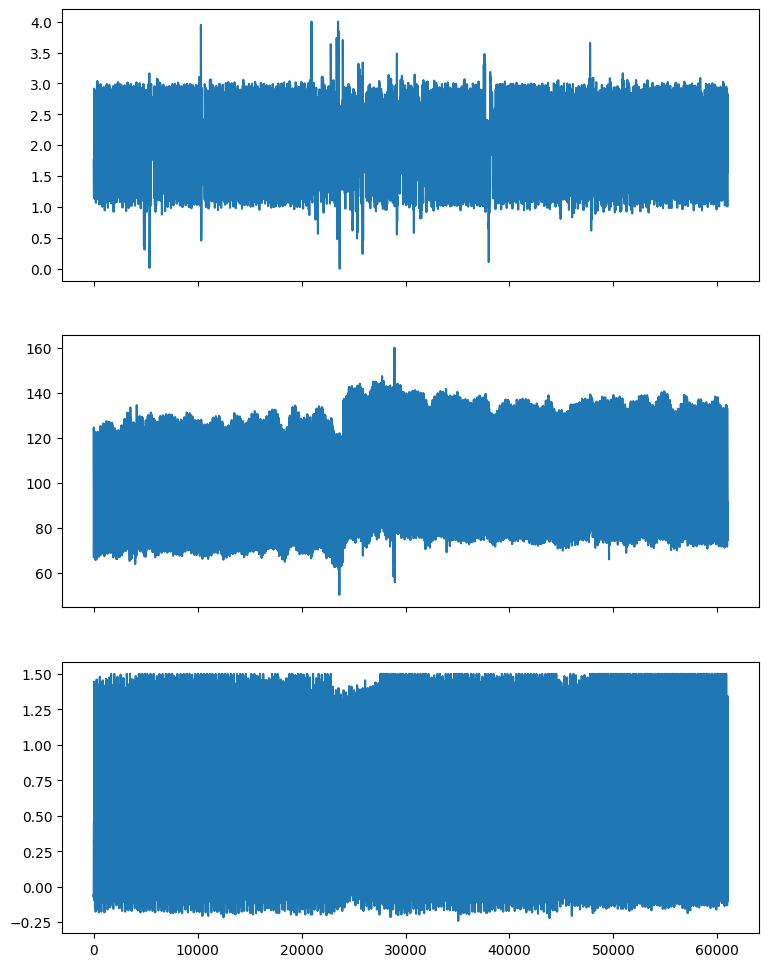

In [4]:
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].plot(sample_file['p'][0][0][0])
ax[1].plot(sample_file['p'][0][0][1])
ax[2].plot(sample_file['p'][0][0][2])

In [5]:
# Loading a sample .mat file to understand the data dimensions
test_sample = scipy.io.loadmat("part_1.mat")['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [6]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125


print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [7]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

In [8]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [9]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


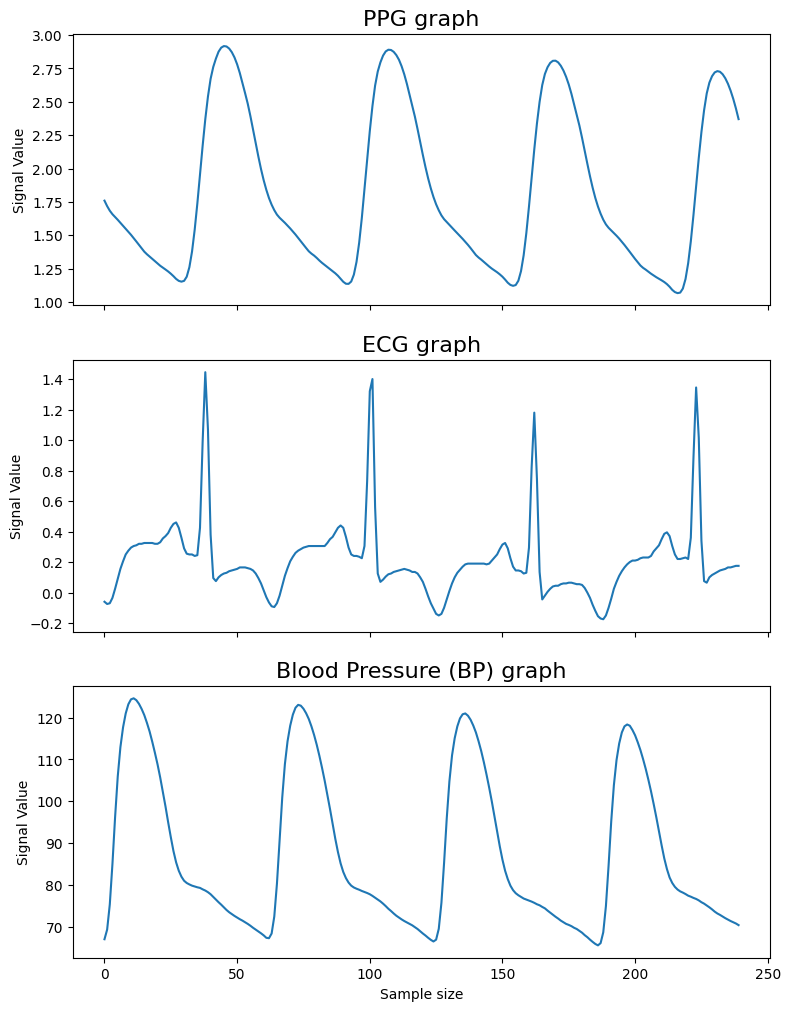

In [10]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:240])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:240])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:240])

In [11]:
# Assume 'data' is your input data
# Step 1: Identify Outliers
input_ppg = ecg[:125]

mean = np.mean(input_ppg)
std_dev = np.std(input_ppg)
threshold = 10  # Adjust this threshold based on your data and requirements
outlier_indices = np.where(np.abs((input_ppg - mean) / std_dev) > threshold)[0]

# Step 2: Remove Outliers
clean_data = np.delete(input_ppg, outlier_indices, axis=0)

# Step 3: Normalize Data
normalized_data = (clean_data - np.mean(clean_data, axis=0)) / np.std(clean_data, axis=0)

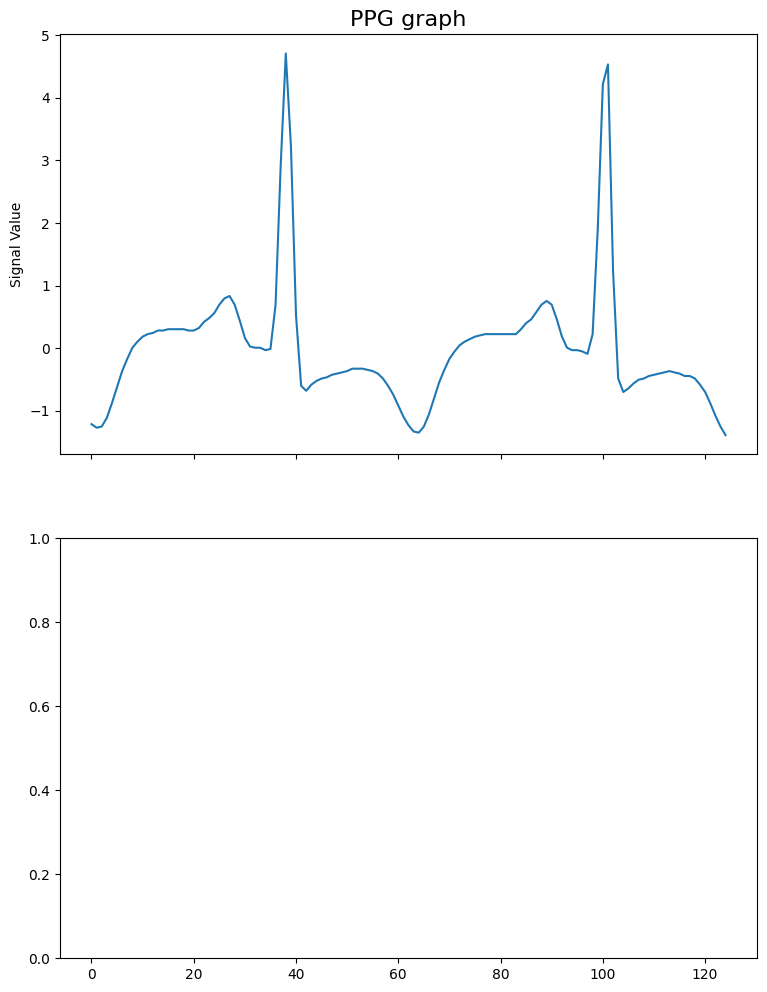

In [12]:
fig, ax = plt.subplots(2,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(normalized_data)

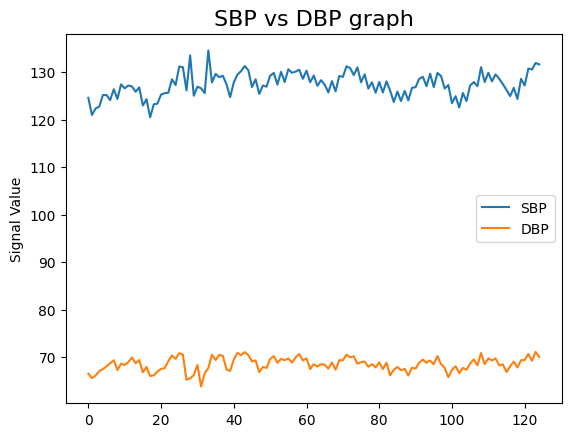

In [13]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])